***Code to calculate the before and after registration metrics on all tissues and plot box plots***

Last edited on 15/04/2024

The metrics csv file stored at: /nfs2/forGaurav/yesbackup/DAPI_reg/final_metrics

In [3]:
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from my_utils import Utils
import glob
import re
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
from my_utils import Utils
import torch
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
Image.MAX_IMAGE_PIXELS = None
def extract_round_number(filename):
    match = re.search(r'_ROUND_(\d+)_', filename)
    if match:
        return int(match.group(1))
    else:
        return 0
#Step 1: Load the images and apply the masks
tissue_names_file='/nfs2/baos1/rudravg/tissue_names.txt'
original_tissues_path='/nfs2/baos1/rudravg'

raw_dir='/home-local/rudravg/Segmentation_test/Images'
mask_dir='/home-local/rudravg/Segmentation_test/Masks'
model_path='/home-local/rudravg/test_DAPI/epochs/epoch_50/epoch_50.pth'

#Reading all tissue names
with open(tissue_names_file, 'r') as file:
    tissue_names = [line.strip() for line in file.readlines()]
model,device=Utils.load_model(model_path)


In [7]:
with open('/nfs2/forGaurav/yesbackup/DAPI_reg/final_metricsoutput_version2.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['tissue', 'round_x', 'before_ncc', 'after_ncc','intensity','mean_rmse'])
    for tissue in tqdm(tissue_names,desc='Generating Images and Truths'):
        search_pattern_raw_files = os.path.join(original_tissues_path, tissue + '*')
        matching_files_raw = glob.glob(search_pattern_raw_files)
        sorted_files_raw = sorted(matching_files_raw, key=extract_round_number) #This is important
        mask_search_pattern = os.path.join(original_tissues_path, 'Retention_Masks', tissue + '*')
        mask_files = glob.glob(mask_search_pattern)
        round_0=sorted_files_raw[0]
        if mask_files:
            mask_name = mask_files[0]
            mask=np.array(Image.open(mask_name))
            mask = (mask > 0).astype(int)
        else:
            print(f"Bruh fix mask for {tissue}")
            continue
        for round_x in tqdm(sorted_files_raw[1:]):
            moving,fixed,orig_height,orig_width=Utils.load_images_and_apply_mask(fixed=round_0,moving=round_x,mask=mask_name)
            registered_tissue,L2_warp=Utils.register_tissues(moving=moving,fixed=fixed,model=model,device=device)
            moving_unpadded=moving[:orig_height,:orig_width]
            fixed_unpadded=fixed[:orig_height,:orig_width]
            registered_tissue_unpadded=registered_tissue[:orig_height,:orig_width]
            L2_warp=L2_warp[:orig_height,:orig_width]
            mean_rmse=np.mean(L2_warp)
            intensity_corrected_tissue,intensity_factor=Utils.adjust_intensity(fixed_unpadded,registered_tissue_unpadded)
            before_ncc=Utils.calculate_ncc(fixed_unpadded.ravel(),moving_unpadded.ravel())
            after_ncc=Utils.calculate_ncc(fixed_unpadded.ravel(),registered_tissue_unpadded.ravel())
            writer.writerow([tissue, round_x, before_ncc, after_ncc,intensity_factor,mean_rmse])

Generating Images and Truths:   0%|          | 0/62 [00:00<?, ?it/s]

Generating Images and Truths:   0%|          | 0/62 [06:35<?, ?it/s]


KeyboardInterrupt: 

***Box Plots yaaay***

In [48]:
metrics='/nfs2/forGaurav/yesbackup/DAPI_RegSegNet/final_metricsoutput_version2_masked.csv'
data_loaded = pd.read_csv(metrics)
values_to_remove = ['GCA035ACB_TISSUE01_', 'GCA112ACB_']

# Remove the rows
data_loaded = data_loaded[~data_loaded['tissue'].isin(values_to_remove)]
data_loaded['before_ncc'] = data_loaded['before_ncc'].str.strip('[]').astype(float)
data_loaded['after_ncc'] = data_loaded['after_ncc'].str.strip('[]').astype(float)



In [49]:
unique_tissues = data_loaded['tissue'].unique()
tissue_to_number = {tissue: i+1 for i, tissue in enumerate(unique_tissues)}
data_loaded['tissue_number'] = data_loaded['tissue'].map(tissue_to_number)

# Preparing data for plotting by melting the DataFrame
data_melted = data_loaded.melt(id_vars=['tissue_number'], value_vars=['before_ncc', 'after_ncc'], 
                               var_name='Condition', value_name='NCC Value')



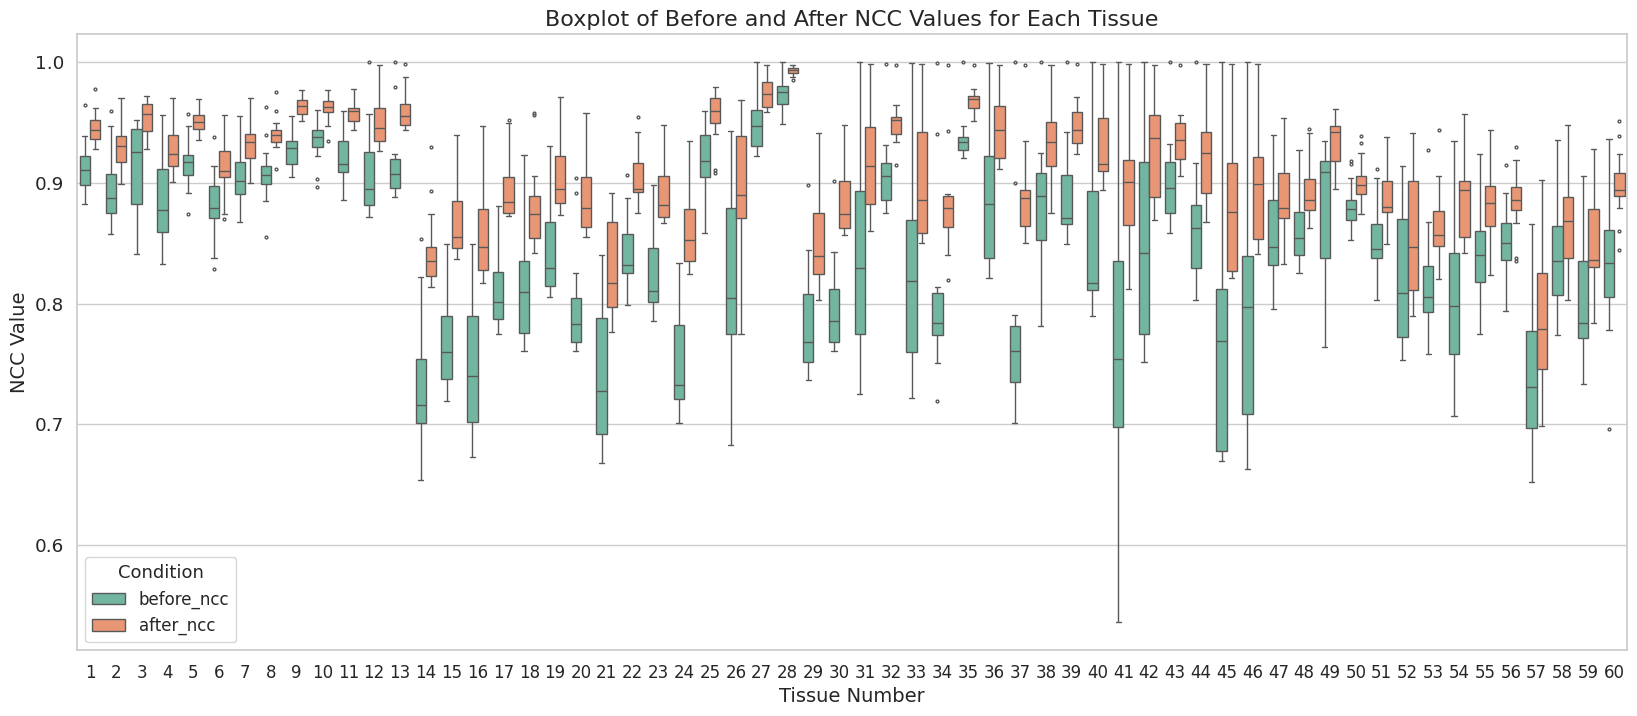

In [50]:
# Set the theme and context
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Create the figure and the boxplot
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x='tissue_number', y='NCC Value', hue='Condition', data=data_melted, palette='Set2', dodge=True, fliersize=2)

# Set the title, labels, and legend
ax.set_title('Boxplot of Before and After NCC Values for Each Tissue', fontsize=16)
ax.set_xlabel('Tissue Number', fontsize=14)
ax.set_ylabel('NCC Value', fontsize=14)
plt.legend(title='Condition', title_fontsize='13', fontsize='12')

# Set the x-ticks
plt.xticks(ticks=range(len(unique_tissues)), labels=[f'{i+1}' for i in range(len(unique_tissues))], fontsize=12)

plt.show()

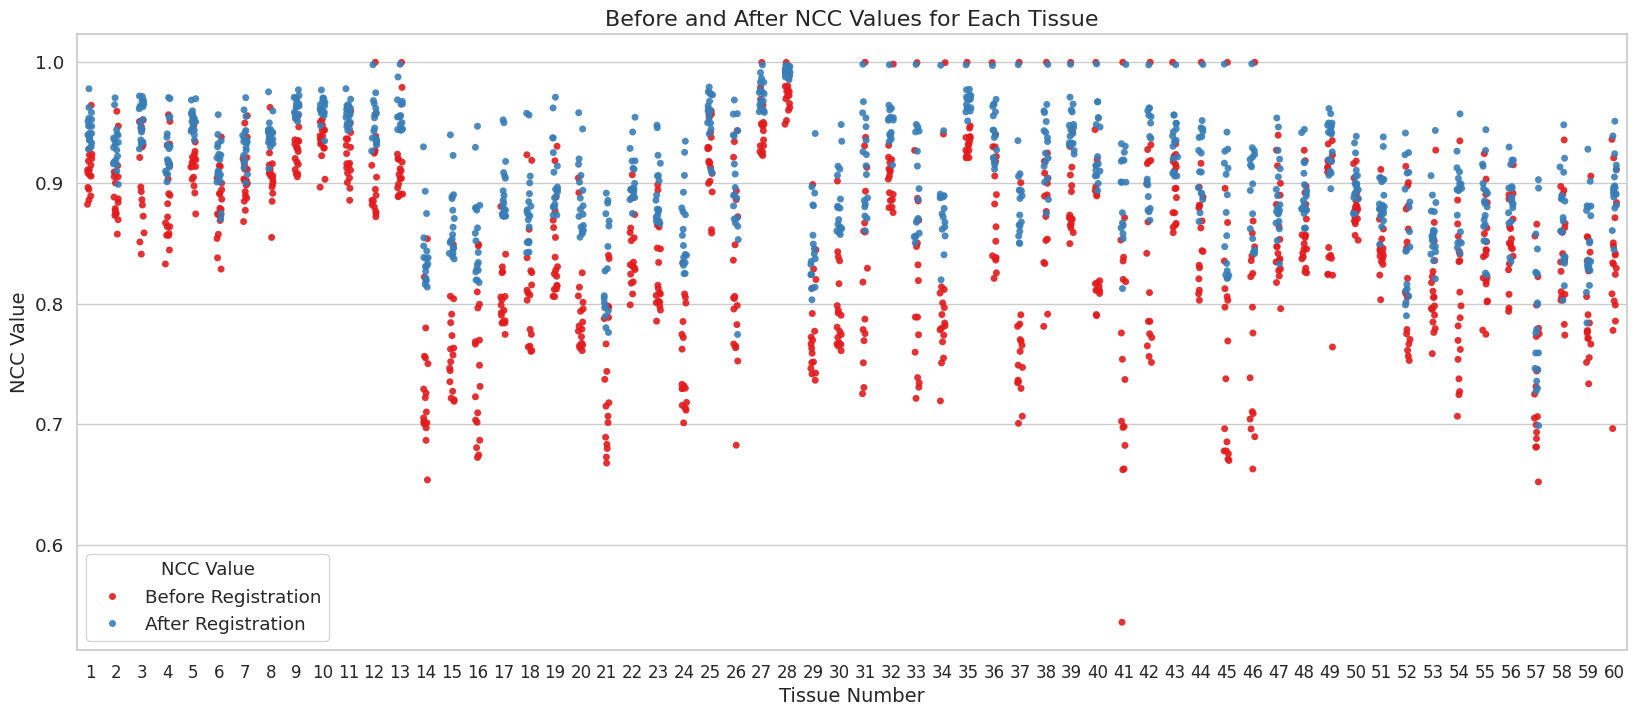

In [51]:
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Create the figure and the stripplot
plt.figure(figsize=(20, 8))
ax = sns.stripplot(x='tissue_number', y='NCC Value', hue='Condition', data=data_melted, palette='Set1', jitter=True, size=5,alpha=0.9)

# Set the title, labels, and legend
ax.set_title('Before and After NCC Values for Each Tissue', fontsize=16)
ax.set_xlabel('Tissue Number', fontsize=14)
ax.set_ylabel('NCC Value', fontsize=14)


# Get the current legend
legend = ax.get_legend()

legend.set_title("NCC Value", prop={"size":13})
new_labels = ['Before Registration', 'After Registration']  # replace with your labels
for t, l in zip(legend.texts, new_labels): t.set_text(l)

# Set the x-ticks
plt.xticks(ticks=range(len(unique_tissues)), labels=[f'{i+1}' for i in range(len(unique_tissues))], fontsize=12)

plt.show()

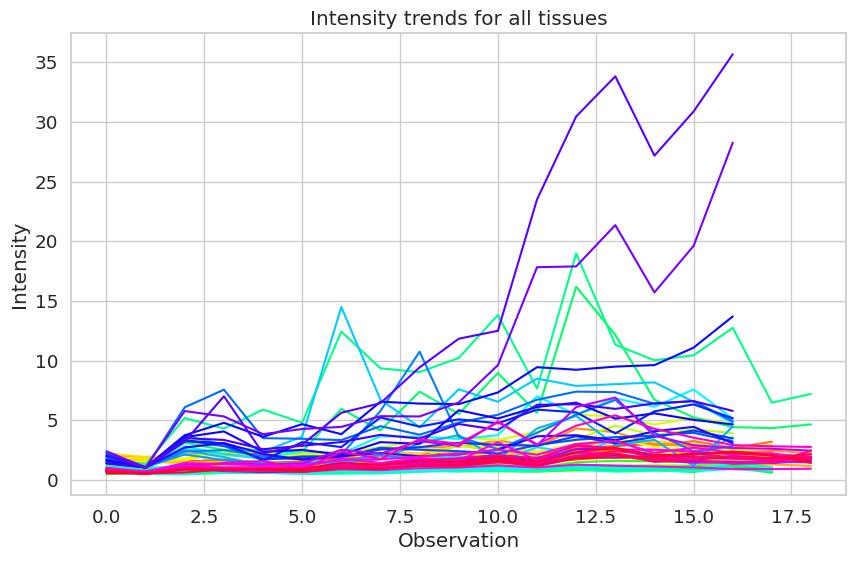

In [52]:
tissues = data_loaded['tissue'].unique()

# Set the color palette
colors = sns.color_palette('hsv', len(tissues))

# Plot the intensity data for each tissue
plt.figure(figsize=(10, 6))
for i, tissue in enumerate(tissues):
    tissue_data = data_loaded[data_loaded['tissue'] == tissue]
    sns.lineplot(x=range(len(tissue_data)), y=tissue_data['intensity'], color=colors[i])

plt.xlabel('Observation')
plt.ylabel('Intensity')
plt.title('Intensity trends for all tissues')
plt.show()

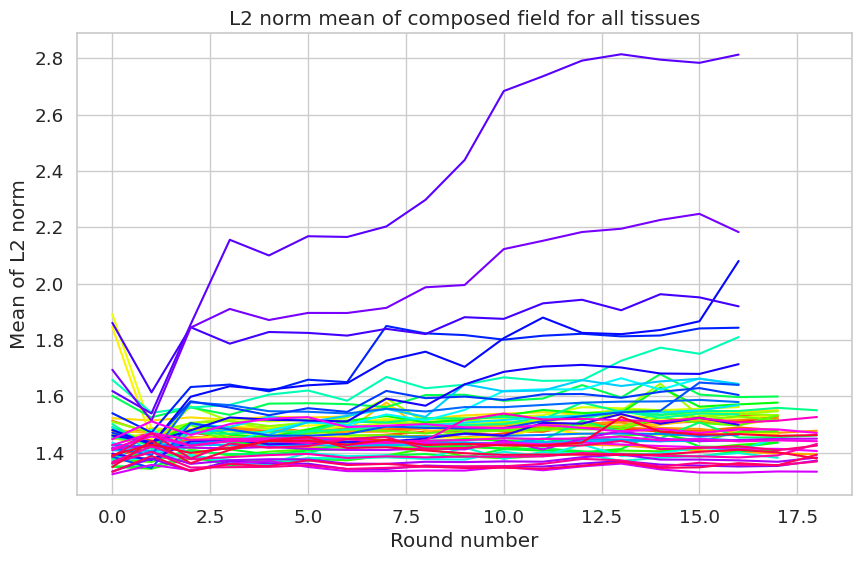

In [53]:
import matplotlib.ticker as ticker
tissues = data_loaded['tissue'].unique()

# Set the color palette
colors = sns.color_palette('hsv', len(tissues))

# Plot the intensity data for each tissue
plt.figure(figsize=(10, 6))
for i, tissue in enumerate(tissues):
    tissue_data = data_loaded[data_loaded['tissue'] == tissue]
    sns.lineplot(x=range(len(tissue_data)), y=tissue_data['mean_rmse'], color=colors[i])

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.xlabel('Round number')
plt.ylabel('Mean of L2 norm')
plt.title('L2 norm mean of composed field for all tissues')
plt.show()

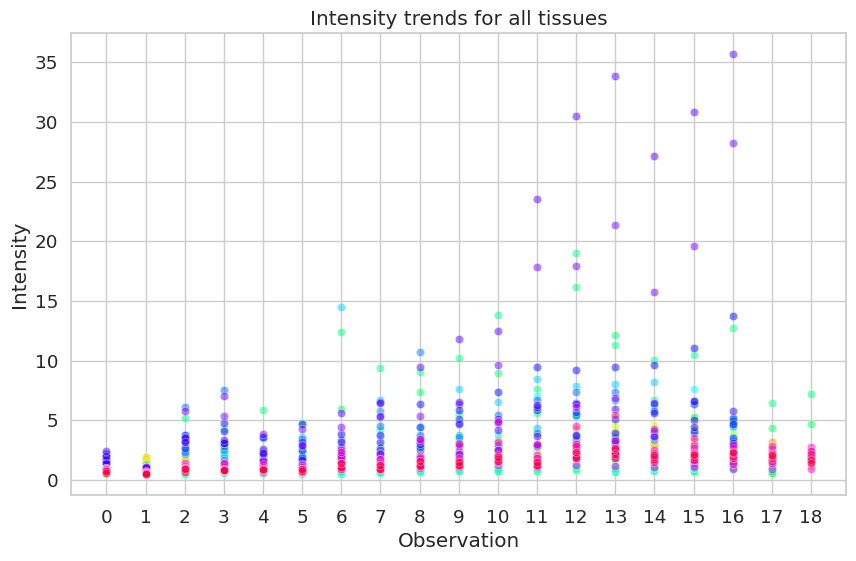

In [31]:
import matplotlib.ticker as ticker

tissues = data_loaded['tissue'].unique()

# Set the color palette
colors = sns.color_palette('hsv', len(tissues))

# Plot the intensity data for each tissue
fig, ax = plt.subplots(figsize=(10, 6))
for i, tissue in enumerate(tissues):
    tissue_data = data_loaded[data_loaded['tissue'] == tissue]
    sns.scatterplot(x=range(len(tissue_data)), y=tissue_data['intensity'], color=colors[i], alpha=0.5)

# Set x-axis labels to round numbers
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.xlabel('Observation')
plt.ylabel('Intensity')
plt.title('Intensity trends for all tissues')
plt.show()

In [32]:
filtered_data = data_loaded[data_loaded['intensity'] > 5]

# Get the unique tissue names
tissue_names = filtered_data['tissue'].unique()

In [34]:
len(tissue_names)

16